# Information spread and influence Maximization in social networks


In this notebook we will explore the network of Game of Thrones characters and simulate information spread and influence maximization in the network.

In [ ]:
# connect google drive to the 
import os
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = "/content/gdrive/MyDrive/"
project_folder = "Colab Notebooks/complex network/project/data"
os.chdir(root_dir+project_folder)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%matplotlib inline
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from itertools import combinations

plt.rcParams["figure.figsize"] = (20,10)
import tqdm as tqdm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#Getting Star Wars social network data

- starwars_edge.csv <br>
  Contains the edges that connects 2 nodes if they are in the same scene.
  scene is the weight of the edge which represents the number of scenes that the 2 characters are seen together.

- starwars_node.csv <br>
 Contains a mapping of the id to the name of the character it represents. 

In [ ]:
# read the starwars_nodes.csv
nodes = pd.read_csv("starwars_nodes.csv")
# read the starwars_edges.csv
edges = pd.read_csv("starwars_edges.csv")

# display the top values for the dataframes 
display(nodes.head())
display(edges.head())

,id,name,scenes
0,106,YOLO ZIFF,4
1,110,NIV LEK,4
2,109,JESS,5
3,108,ELLO ASTY,5
4,107,COLONEL DATOO,4


,source,target,scenes
0,110,93,2
1,110,106,1
2,109,93,2
3,109,106,1
4,109,110,2


# Replace the ID in the edge dataframe with the respective name of the character



In [ ]:
# loop through the rows in the nodes dataframe
for i in range(len(nodes)):
  # replace the source id into the corresponding character name
  edges["source"].mask(edges["source"] == nodes["id"][i],  nodes["name"][i], inplace=True)
  # replace the target id into the corresponding character name
  edges["target"].mask(edges["target"] == nodes["id"][i],  nodes["name"][i], inplace=True)

edges = edges.rename(columns={"scenes":"weight"})
edges.sort_values('weight',ascending=False).head()

,source,target,weight
398,CHEWBACCA,HAN,77
145,HAN,LEIA,69
347,C-3PO,R2-D2,55
332,C-3PO,HAN,54
333,C-3PO,LEIA,49


# Create the networkX graph

In [ ]:
starwars = nx.from_pandas_edgelist(edges, 
                            source='source',
                            target='target',
                            edge_attr='weight' )

In [ ]:
print(nx.info(starwars))

Graph with 110 nodes and 444 edges


#Analyse weights across the graph

In [ ]:
weighted_degrees = dict(nx.degree(starwars,weight='weight'))
max_degree = max(weighted_degrees.values())

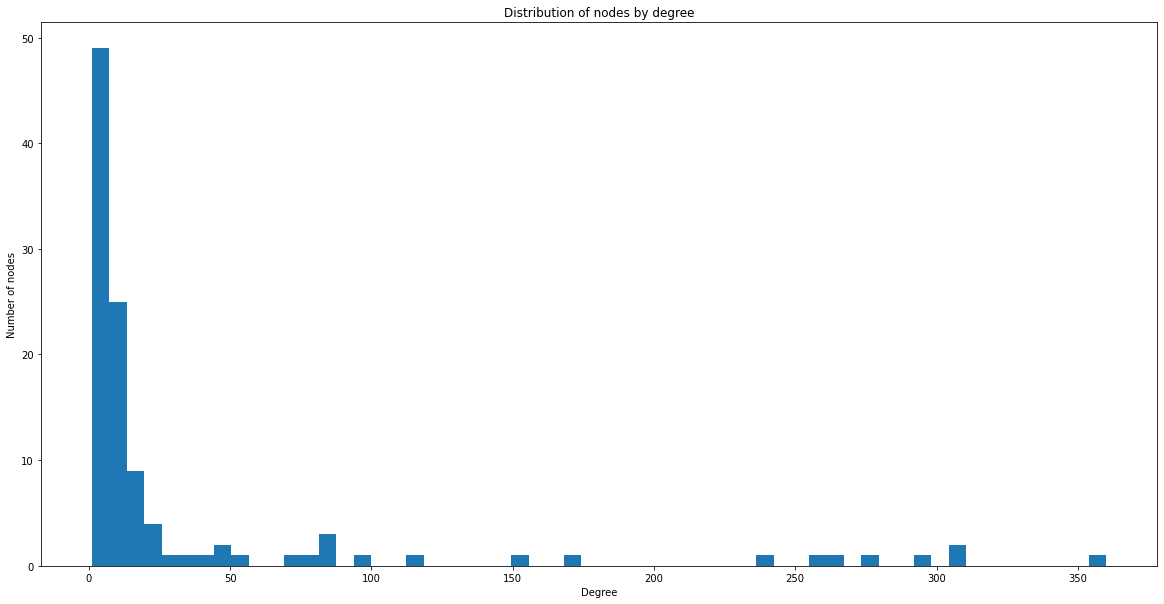

In [ ]:
plt.hist(weighted_degrees.values(), bins="auto")

plt.title("Distribution of nodes by degree")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")

plt.show()

#Create the layout and display graph

In [ ]:
# get the position of the nodes using spring layout
pos = nx.spring_layout(starwars,weight='weight',iterations=100, k = 5)

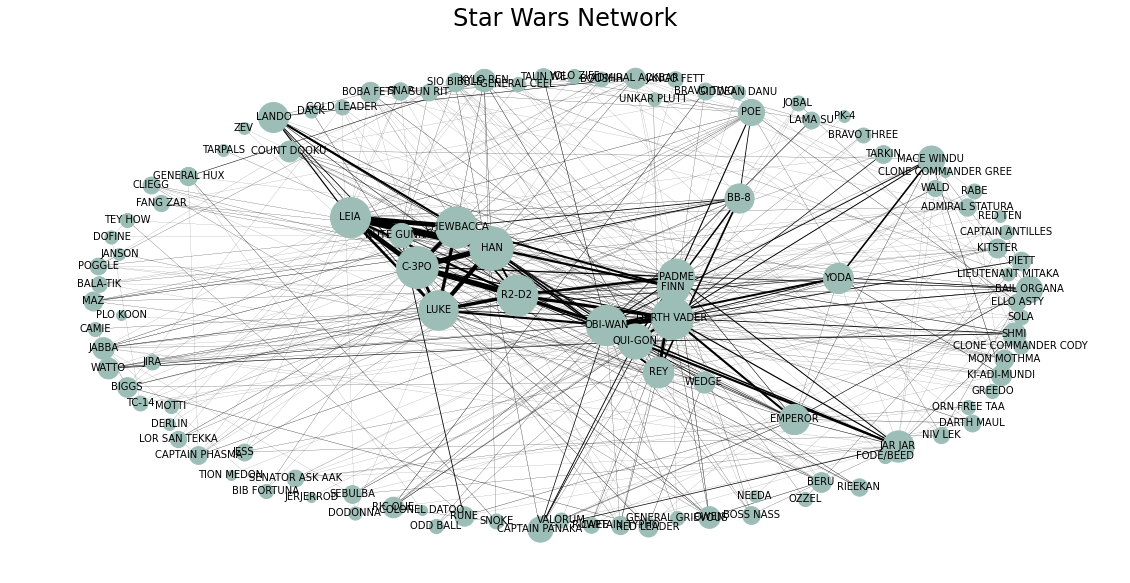

In [ ]:
plt.axis('off')
plt.title('Star Wars Network',fontsize = 24)

# loop through the nodes in the starwars network
for node in starwars.nodes():
  # set the size of the nodes relative to the number of edges it has
  size = 100*weighted_degrees[node]**0.5
  # draw the node
  ns = nx.draw_networkx_nodes(starwars,pos,nodelist=[node], node_size=size, node_color='#9dbeb7')

nx.draw_networkx_labels(starwars,pos,{n: n for n in starwars},font_size=10)

# loops through the edges to change their width base on the weight
for e in starwars.edges(data=True):
    nx.draw_networkx_edges(starwars,pos,[e],width=e[2]['weight']/10,edge_color='#000000')

#Identifying influencers in the network

In [ ]:
# create the dataframe for the top influencers based on common methods
top = pd.DataFrame.from_dict(dict(nx.degree(starwars)),orient='index').sort_values(0,ascending=False)
# assign the frist column as the degree
top.columns = ['Degree']

display(top.sort_values('Degree',ascending=False)[:4])

# calculate the weighted degree for the network 
weighted_degrees_column = pd.DataFrame.from_dict(dict(nx.degree(starwars,weight='weight')),orient='index')
# set the column name to the method
weighted_degrees_column.columns = ['Weighted Degree']
# display top weighted degree nodes
display(weighted_degrees_column.sort_values('Weighted Degree',ascending=False)[:4])
# add the weighted degree to top dataframe
top['Weighted Degree'] =  weighted_degrees_column

# calculate the pagerank for the network 
pagerank_column = pd.DataFrame.from_dict(dict(nx.pagerank(starwars,weight='weight')),orient='index')
# set the column name to the method
pagerank_column.columns = ['PageRank']
# display top nodes based on their pagerank
display(pagerank_column.sort_values('PageRank',ascending=False)[:4])
# add pagerank to the top dataframe
top['PageRank'] = pagerank_column

# calculate the betweenness for the network 
betweenness_column =  pd.DataFrame.from_dict(dict(nx.betweenness_centrality(starwars,weight='weight')),orient='index')
# set the column name to the method
betweenness_column.columns = ['Betweenness']
# display top nodes based on their betweeness centrality
display(betweenness_column.sort_values('Betweenness',ascending=False)[:4])
# add betweeness centrality to the top dataframe
top['Betweenness'] = betweenness_column

# display the top dataframe holding the value of all the methods
top.head()

,Degree
DARTH VADER,52
OBI-WAN,36
C-3PO,35
PADME,34


,Weighted Degree
HAN,360
C-3PO,310
DARTH VADER,309
CHEWBACCA,297


,PageRank
DARTH VADER,0.071735
HAN,0.058487
OBI-WAN,0.057067
C-3PO,0.052838


,Betweenness
DARTH VADER,0.203720
C-3PO,0.183109
OBI-WAN,0.145388
LEIA,0.134598


,Degree,Weighted Degree,PageRank,Betweenness
DARTH VADER,52,309,0.071735,0.203720
OBI-WAN,36,261,0.057067,0.145388
C-3PO,35,310,0.052838,0.183109
PADME,34,173,0.038425,0.070902
QUI-GON,27,152,0.034205,0.065977


In [ ]:
print(nx.info(starwars))

Graph with 110 nodes and 444 edges


## For different budgets lets compare the centrality metrics for seeding

##Simulate independent cascade:

In [ ]:
# needs to be calculated on the inside but since it does not change we can caluculate it once only 
max_weight = max([e[2]['weight'] for e in starwars.edges(data=True)])

def independent_cascade(G,t,infection_times):
  #doing a t->t+1 step of independent_cascade simulation
  #each infectious node infects neigbors with probabilty proportional to the weight

  # determine the max weight to create a ratio for the influence
  # max_weight = max([e[2]['weight'] for e in G.edges(data=True)])
  # get the nodes that will try to influence the network for time t
  current_infectious = [n for n in infection_times if infection_times[n]==t]
  # loops through the nodes
  for n in current_infectious:
    # loops through the neighbors of the selected node
    for v in G.neighbors(n):
      # check if the neighbor selected is not already influenced
      if v not in infection_times:
        # try to influence the node
        if  G.get_edge_data(n,v)['weight'] >= np.random.random()*max_weight:
          infection_times[v] = t+1

          
  return infection_times

In [ ]:
# create an array of all the methods 
methods = top.columns

# get the number of nodes in the network
max_budget = len(starwars.nodes())
# number of trials since independ cascade has some randomness
trials = 50
# store the results of the different budgets
all_results = []
# progress bar decorator
for budget in tqdm.tqdm_notebook(range(max_budget)):
  # set the value for budget column for the number of seed influencers 
  results = {'budget':budget}
  # loops through the different methods of defining centrality
  for method in methods:
    # set the infections to be empty at the start t=0
    infections = []
    # loops for the number of trials
    for i in range(trials):
      # reset the number of infected nodes
      infected = 0
      # reset the time t to 0
      t= 0
      # infect the nodes in the budget for time t=0
      infection_times = {n:0 for n in top.sort_values(method,ascending=False).index[:budget]}
      # continue infecting nodes in the network until no more infection is possible
      while len(infection_times)>infected:
        #t+=1
        # set the number of already infected node before t+=1 round
        infected = len(infection_times)
        # calculate the new infected nodes
        infection_times = independent_cascade(starwars,t,infection_times)
        # increment the time
        t+=1
      # append the total number of infected nodes in this trial 
      infections.append(infected)
    # append the average number of infection for the method as a ratio of the total graph
    results[method] = np.round(np.mean(infections)/len(starwars.nodes()),2)
  # append the results for the different methods for the budget
  all_results.append(results)

<ipython-input-36-ae7a17c608f7>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for budget in tqdm.tqdm_notebook(range(max_budget)):


  0%|          | 0/110 [00:00<?, ?it/s]

In [ ]:
# concatenate all the results for the different budget into a dataframe 
res_df = pd.concat([pd.DataFrame.from_dict(r,orient='index').T 
                        for r in all_results]).set_index('budget')

In [ ]:
# make the index as a ratio of the graph (optional)
res_df.index = res_df.index/len(starwars.nodes())

In [ ]:
res_df.head()

,Degree,Weighted Degree,PageRank,Betweenness
budget,,,,
0.0,0.00,0.00,0.00,0.00
1.0,0.16,0.17,0.16,0.14
2.0,0.16,0.17,0.17,0.17
3.0,0.17,0.17,0.18,0.17
4.0,0.18,0.17,0.18,0.18


### Compare the methods on a plot (percentage of infected network)

Text(0.5, 0, 'Seeding Budget (out of graph size)')

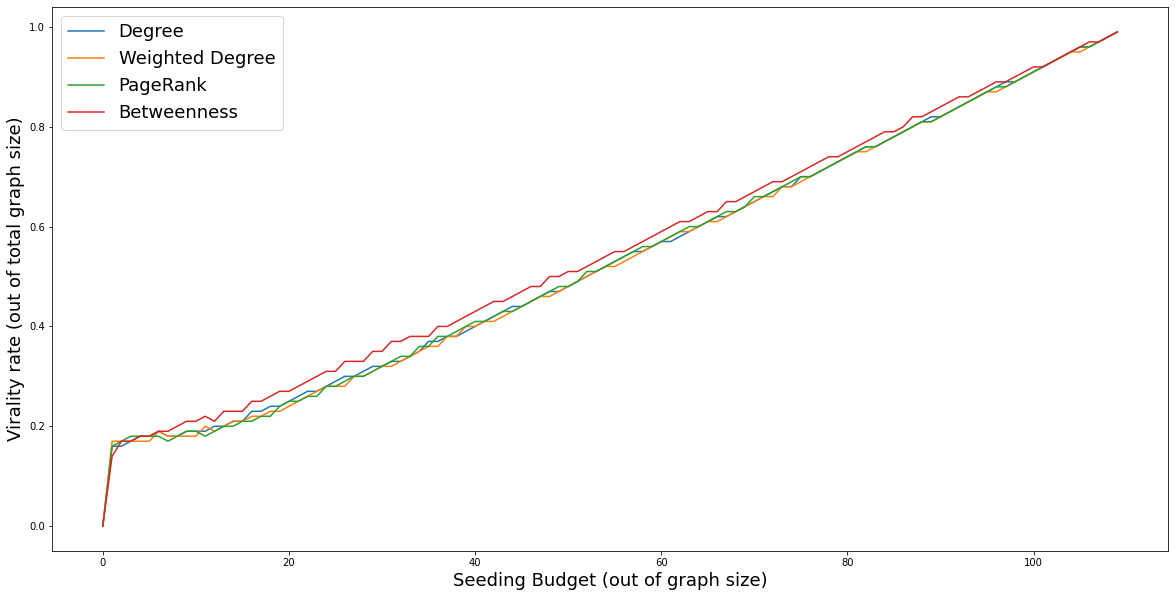

In [ ]:
res_df.plot()
plt.legend(fontsize = 18)
plt.ylabel('Virality rate (out of total graph size)',fontsize = 18)
plt.xlabel('Seeding Budget (out of graph size)', fontsize = 18)

The betweeness measure of centrality performed better than the other methods at all ratio of the network. the spread/ virality rate\* seems to plateau after the introduction of the first few influencers (2-3). After the plateau there is somewhat of a linear relationship between the seed set and the virality rate\*.<br>

<h5>
<b>virality rate</b>: the average percentage of the graph that was influence across the trials for each seed set size.
</h5> 

#Influence maximization using diffusion models

In [ ]:
infection_times = {}

### Finding the best seed set of size 1, 2, 3 and 4 by brute force search

In [ ]:
# number of trials since independ cascade has some randomness
trials = 15
# store the results for the different seed set sizes
all_results = []
# change the seed set sizes
for budget in range(1,5):
  # store the percentage of the network that was influenced for the budget size
  results = {'budget':budget}
  # print the budget size which is going to be simulated
  print(f"budget size: {budget}")
  # create the combinations of nodes for the budget size
  seed_sets = list(combinations(starwars.nodes(),budget))
  # loop through the different combinations sizes (draw progress bar)
  for seed in tqdm.tqdm_notebook(seed_sets[:]):
    # store the nodes that are infected
    infections = []
    # run 15 simulations
    for i in range(trials):
      # store the total number of infected nodes
      infected = 0
      # store the time iteration
      t= 0
      # infect the nodes in the network that are part of the seed set
      infection_times = {n:0 for n in seed}
      # loop as far as nodes are being infected
      while len(infection_times)>infected:
        # update the number of infected persons at the start of iteration t
        infected = len(infection_times)
        # run the independent cascade model
        infection_times = independent_cascade(starwars,t,infection_times)
        # increment time iteration
        t+=1
      # store the number of nodes that were infected in the trial
      infections.append(infected)
    # store the average percentage of the graph that was infected for the seed set
    results[seed] = np.round(np.mean(infections)/len(starwars.nodes()),2)
  # store the results of the different seed sets
  all_results.append(results)

budget size: 1


<ipython-input-20-9971543d3baf>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for seed in tqdm.tqdm_notebook(seed_sets[:]):


  0%|          | 0/110 [00:00<?, ?it/s]

budget size: 2


  0%|          | 0/5995 [00:00<?, ?it/s]

budget size: 3


  0%|          | 0/215820 [00:00<?, ?it/s]

budget size: 4


  0%|          | 0/5773185 [00:00<?, ?it/s]

In [ ]:
# display the top 10 seed sets of the different seed sets sizes
for results in all_results:
  print(sorted(results.items(), key = lambda x: x[1], reverse=True)[:10])

[('budget', 1), (('PADME',), 0.18), (('R2-D2',), 0.18), (('C-3PO',), 0.17), (('LUKE',), 0.17), (('LEIA',), 0.16), (('HAN',), 0.16), (('CHEWBACCA',), 0.16), (('DARTH VADER',), 0.16), (('OBI-WAN',), 0.15)]
[('budget', 2), (('OBI-WAN', 'BRAVO THREE'), 0.22), (('NIV LEK', 'OBI-WAN'), 0.2), (('JESS', 'LEIA'), 0.2), (('JESS', 'R2-D2'), 0.2), (('C-3PO', 'RUNE'), 0.2), (('C-3PO', 'BRAVO THREE'), 0.2), (('LEIA', 'GIDDEAN DANU'), 0.2), (('HAN', 'TAUN WE'), 0.2), (('KYLO REN', 'PADME'), 0.2)]
[('budget', 3), (('JESS', 'C-3PO', 'BOSS NASS'), 0.22), (('ELLO ASTY', 'C-3PO', 'NEEDA'), 0.22), (('COLONEL DATOO', 'LEIA', 'JANGO FETT'), 0.22), (('ADMIRAL STATURA', 'LEIA', 'SOLA'), 0.22), (('C-3PO', 'CLONE COMMANDER GREE', 'TAUN WE'), 0.22), (('C-3PO', 'GENERAL CEEL', 'BERU'), 0.22), (('C-3PO', 'TC-14', 'POGGLE'), 0.22), (('C-3PO', 'PIETT', 'WALD'), 0.22), (('C-3PO', 'KI-ADI-MUNDI', 'ODD BALL'), 0.22)]
[('budget', 4), (('LUKE', 'ORN FREE TAA', 'RUNE', 'BOBA FETT'), 0.25), (('POE', 'LEIA', 'UNKAR PLUTT', '

#Closer look at how the spread occured

In [ ]:
def plot_G(G,pos,infection_times,t):
  # store the nodes that have been infected at time t
  current_infectious = [n for n in infection_times if infection_times[n]==t]
  plt.figure()
  plt.axis('off')
  # add a title to the graph
  plt.title('Star Wars Network, t={}'.format(t),fontsize = 24)

  # loops through the nodes in the network 
  for node in G.nodes():
    # calculate the size of the node based on the nodes degree
    size = 100*weighted_degrees[node]**0.5
    # check if the node was infected at that time iteration t
    if node in current_infectious:
      # draw node with a red fill color
      ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#e73213')
    elif infection_times.get(node,9999999)<t:
      # draw the node with a cream fill color
      ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#efe6d5')
    else:
      # draw the node with a green fill color
      ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#9dbeb7')

  # label the nodes
  nx.draw_networkx_labels(G,pos,{n: n for n in G},font_size=10);

  # loops through the edges 
  for e in G.edges(data=True):
    # draw the edge with a thickness based on the number of scenes they were together 
    nx.draw_networkx_edges(G,pos,[e],width=e[2]['weight']/10,edge_color='#000000')

  # save the plot to storage 
  plt.savefig(f"Graph{t}.png", format="PNG")

In [ ]:
# name: t
infection_times = {'HAN':0, 'DARTH VADER':0, 'OBI-WAN':0} # best 3 nodes using pagerank
# infection_times = {'DACK':0, 'DARTH VADER':0} # best pair using independent cascade
# infection_times = {'BOUSHH':0, 'NIV LEK':0, 'OBI-WAN':0} # best 3 nodes using independent cascade

# store the number of people infected in the previous iteration 
prev_infected = 0
# time t
t = 0
# loops while there are more people getting infected
while len(infection_times) > prev_infected:
  # plot the image to the screen
  plot_G(starwars,pos,infection_times,t)
  # update the number of people infected
  prev_infected = len(infection_times)
  # update the list of infected person
  infection_times = independent_cascade(starwars,t,infection_times)
  # increment the time t
  t+=1
else:
  # print the last graph where the maximum number of nodes have already been infected
  plot_G(starwars,pos,infection_times,t)

Output hidden; open in https://colab.research.google.com to view.

#Linear Threshold
Another well known model is the linear threshold which work kind of like peer pressure. In this model every infected node adds a sort of influence to their neighbors, once that total influence for a node is greater than or equal to a certain threshold, that node is marked as influenced and will influence their neighbors in the next iteration.

In [ ]:
# will usually need to be inside
max_weight = max([e[2]['weight'] for e in starwars.edges(data=True)])

def linear_threshold(cG,t,infection_times, threshold_ratio):
  #doing a t->t+1 step of independent_cascade simulation

  # create the threshold to be reached in order to mark as influenced
  # threshold = threshold_ratio * max([e[2]['weight'] for e in G.edges(data=True)])
  threshold = threshold_ratio * max_weight

  current_infectious = [n for n in infection_times if infection_times[n]==t]
  # loops through the infected nodes
  for n in current_infectious:
    # loops through the neighbors of the selected node
    for v in cG.neighbors(n):
      # check if the neighbor selected is not already influenced
      if v not in infection_times:
        # add influence to the neighbor
        nx.set_node_attributes(cG, {v:{"influence":cG.nodes[v]["influence"] + cG.get_edge_data(n,v)['weight']}})
        # check if the node was influenced
        if cG.nodes[v]["influence"] >= threshold:
          infection_times[v] = t+1
          
  return infection_times

##Finding the best seed set for different budgets (using Linear threshold)

In [ ]:
all_results_lt = []
for budget in range(1,5):
  results = {'budget':budget}
  print(f"budget size: {budget}")
  seed_sets = list(combinations(starwars.nodes(),budget))
  for seed in tqdm.tqdm_notebook(seed_sets[:]):
      infections = []
      infected = 0
      t= 0
      infection_times = {n:0 for n in seed}
      # create a copy in order not to save the sum of influence in the original graph
      cG = starwars.copy()
      nx.set_node_attributes(cG, 0, "influence")
      while len(infection_times)>infected:
          #t+=1
          infected = len(infection_times)
          infection_times = linear_threshold(cG,t,infection_times,0.4)
          t+=1
      infections.append(infected)
      results[seed] = np.round(np.mean(infections)/len(starwars.nodes()),2)

  all_results_lt.append(results)

budget size: 1


<ipython-input-21-bb1426bb0bc8>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for seed in tqdm.tqdm_notebook(seed_sets[:]):


  0%|          | 0/110 [00:00<?, ?it/s]

budget size: 2


  0%|          | 0/5995 [00:00<?, ?it/s]

budget size: 3


  0%|          | 0/215820 [00:00<?, ?it/s]

budget size: 4


  0%|          | 0/5773185 [00:00<?, ?it/s]

In [ ]:
# display the top 20 seed sets of the different seed sets sizes
for results in all_results_lt:
  print(sorted(results.items(), key = lambda x: x[1], reverse=True)[:20])

[('budget', 1), (('C-3PO',), 0.18), (('LEIA',), 0.18), (('HAN',), 0.18), (('LUKE',), 0.18), (('PADME',), 0.18), (('OBI-WAN',), 0.18), (('CHEWBACCA',), 0.18), (('R2-D2',), 0.18), (('DARTH VADER',), 0.18), (('NIV LEK',), 0.01), (('POE',), 0.01), (('YOLO ZIFF',), 0.01), (('JESS',), 0.01), (('SNAP',), 0.01), (('ELLO ASTY',), 0.01), (('COLONEL DATOO',), 0.01), (('GENERAL HUX',), 0.01), (('ADMIRAL STATURA',), 0.01), (('FINN',), 0.01)]
[('budget', 2), (('ELLO ASTY', 'C-3PO'), 0.2), (('ELLO ASTY', 'LEIA'), 0.2), (('ELLO ASTY', 'HAN'), 0.2), (('ELLO ASTY', 'LUKE'), 0.2), (('ELLO ASTY', 'PADME'), 0.2), (('ELLO ASTY', 'OBI-WAN'), 0.2), (('ELLO ASTY', 'CHEWBACCA'), 0.2), (('ELLO ASTY', 'R2-D2'), 0.2), (('ELLO ASTY', 'DARTH VADER'), 0.2), (('C-3PO', 'LOR SAN TEKKA'), 0.2), (('LEIA', 'LOR SAN TEKKA'), 0.2), (('HAN', 'LOR SAN TEKKA'), 0.2), (('LUKE', 'LOR SAN TEKKA'), 0.2), (('PADME', 'LOR SAN TEKKA'), 0.2), (('OBI-WAN', 'LOR SAN TEKKA'), 0.2), (('LOR SAN TEKKA', 'CHEWBACCA'), 0.2), (('LOR SAN TEKKA'

#Stored Diffusion

In [ ]:
from sys import getsizeof

# store the infleunce of the node for future use
# (node: [influenced_node, influenced_node, influenced_node])
nodes_influence = {}

def get_influence(G, n):
  '''
    determine the neighbors of the node that will be influenced by the node
  '''
  # max_weight use to calculate influence 
  max_weight = max([e[2]['weight'] for e in G.edges(data=True)])
  # number of trials since infleunce is random
  trials = 20
  # minimum amount of trials for which the node has to be influence to be marked as influence 
  influence_threshold = trials / 5.2
  # store the nodes that are being influence by the node
  n_infleunce = []
  # loop through the neighbors of the node n 
  for v in G.neighbors(n):
    # the number of trials for the node was influenced 
    influenced_trials = 0
    # run multiple trial
    for i in range(trials):
      # try to infleunce
      if  G.get_edge_data(n,v)['weight'] >= np.random.random()*max_weight:
        influenced_trials += 1

    # check if number of trials where the neighbor got influence is greater than the threshold 
    if influenced_trials > influence_threshold:
      # mark the neighbor as a node that will be influence by the node
      n_infleunce.append(v)

  return n_infleunce



# build stored for the network
def store_influence(G):
  # loop thorugh the nodes
  for n in tqdm.notebook.tqdm(G):
    # calculate and store the neighbors of the node n that will be influenced by it
    nodes_influence[n] = get_influence(G, n)
  # show the memory space used to store the infleunce of all the nodes in the graph
  print("size of stored:", getsizeof(nodes_influence) / 1024 , "MB")
      

def stored_diffusion(G,t,infection_times):
  # get the nodes that will try to influence the network for time t
  current_infectious = [n for n in infection_times if infection_times[n]==t]
  # loops through the nodes
  for n in current_infectious:
    # get influence from stored
    for v in nodes_influence[n]:
      # check if the 
      if not v in infection_times:
        infection_times[v] = t+1
          
  return infection_times

In [ ]:
all_results_stored = []

print("building stored...")
store_influence(starwars)

print("\nrunning simulation")
for budget in range(1,5):
  results = {'budget':budget}
  print(f"budget size: {budget}")
  seed_sets = list(combinations(starwars.nodes(),budget))
  for seed in tqdm.notebook.tqdm(seed_sets[:]):
    infections = []
    infected = 0
    t= 0
    infection_times = {n:0 for n in seed}
    while len(infection_times)>infected:
      #t+=1
      infected = len(infection_times)
      infection_times = stored_diffusion(starwars,t,infection_times)
      t+=1
    infections.append(infected)
    results[seed] = np.round(np.mean(infections)/len(starwars.nodes()),2)

  all_results_stored.append(results)

for results in all_results_stored:
  print(sorted(results.items(), key = lambda x: x[1], reverse=True)[:20])

building stored...


  0%|          | 0/110 [00:00<?, ?it/s]

size of stored: 4.5859375 MB

running simulation
budget size: 1


  0%|          | 0/110 [00:00<?, ?it/s]

budget size: 2


  0%|          | 0/5995 [00:00<?, ?it/s]

budget size: 3


  0%|          | 0/215820 [00:00<?, ?it/s]

budget size: 4


  0%|          | 0/5773185 [00:00<?, ?it/s]

[('budget', 1), (('JABBA',), 0.19), (('BAIL ORGANA',), 0.19), (('C-3PO',), 0.18), (('LEIA',), 0.18), (('FINN',), 0.18), (('HAN',), 0.18), (('LUKE',), 0.18), (('LANDO',), 0.18), (('YODA',), 0.18), (('PADME',), 0.18), (('OBI-WAN',), 0.18), (('JAR JAR',), 0.18), (('EMPEROR',), 0.18), (('CHEWBACCA',), 0.18), (('REY',), 0.18), (('R2-D2',), 0.18), (('DARTH VADER',), 0.18), (('QUI-GON',), 0.18), (('BB-8',), 0.02)]
[('budget', 2), (('NIV LEK', 'JABBA'), 0.2), (('NIV LEK', 'BAIL ORGANA'), 0.2), (('YOLO ZIFF', 'JABBA'), 0.2), (('YOLO ZIFF', 'BAIL ORGANA'), 0.2), (('JESS', 'JABBA'), 0.2), (('JESS', 'BAIL ORGANA'), 0.2), (('SNAP', 'JABBA'), 0.2), (('SNAP', 'BAIL ORGANA'), 0.2), (('ELLO ASTY', 'JABBA'), 0.2), (('ELLO ASTY', 'BAIL ORGANA'), 0.2), (('COLONEL DATOO', 'JABBA'), 0.2), (('COLONEL DATOO', 'BAIL ORGANA'), 0.2), (('GENERAL HUX', 'JABBA'), 0.2), (('GENERAL HUX', 'BAIL ORGANA'), 0.2), (('ADMIRAL STATURA', 'JABBA'), 0.2), (('ADMIRAL STATURA', 'BAIL ORGANA'), 0.2), (('SNOKE', 'JABBA'), 0.2), ((

Visualize influence using the stored independent cascade

In [ ]:
infection_times = { 'NIV LEK':0, 'YOLO ZIFF':0, 'JABBA':0} # best 3 nodes using stored independent cascade
# store the number of people infected in the previous iteration 
prev_infected = 0
# time t
t = 0
# loops while there are more people getting infected
while len(infection_times) > prev_infected:
  # plot the image to the screen
  plot_G(starwars,pos,infection_times,t)
  # update the number of people infected
  prev_infected = len(infection_times)
  # update the list of infected person
  infection_times = stored_diffusion(starwars,t,infection_times)
  # increment the time t
  t+=1
else:
  # print the last graph where the maximum number of nodes have already been infected
  plot_G(starwars,pos,infection_times,t)

Output hidden; open in https://colab.research.google.com to view.